In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
commodities = ['Maize', 'Wheat', 'Oats', 'Soybeans']
DATA_PATH = 'processed_data'
Y_COLUMN = 'Sep'
PROBLEM_PVALUE = 0.05

## Initial Analysis

In [3]:
dataset = pd.read_csv(f'{DATA_PATH}/full_dataset.csv')
dataset.columns

Index(['Date', 'Maize Mar', 'Maize May', 'Maize Jul', 'Maize Sep', 'Oats Mar',
       'Oats May', 'Oats Jul', 'Oats Sep', 'Soybeans Mar', 'Soybeans May',
       'Soybeans Jul', 'Soybeans Sep', 'Wheat Mar', 'Wheat May', 'Wheat Jul',
       'Wheat Sep', 'diff', 'Prime'],
      dtype='object')

In [4]:
# for commodity in commodities:
#     dataset = pd.read_csv(f'{DATA_PATH}/full_{commodity}.csv')
#     dataset = dataset[['Mar', 'May', 'Jul', 'Sep', 'Prime']]
#     correlation_matrix = dataset.corr()
#     print(f'Correlation matrix for {commodity}:\n', correlation_matrix, '\n')

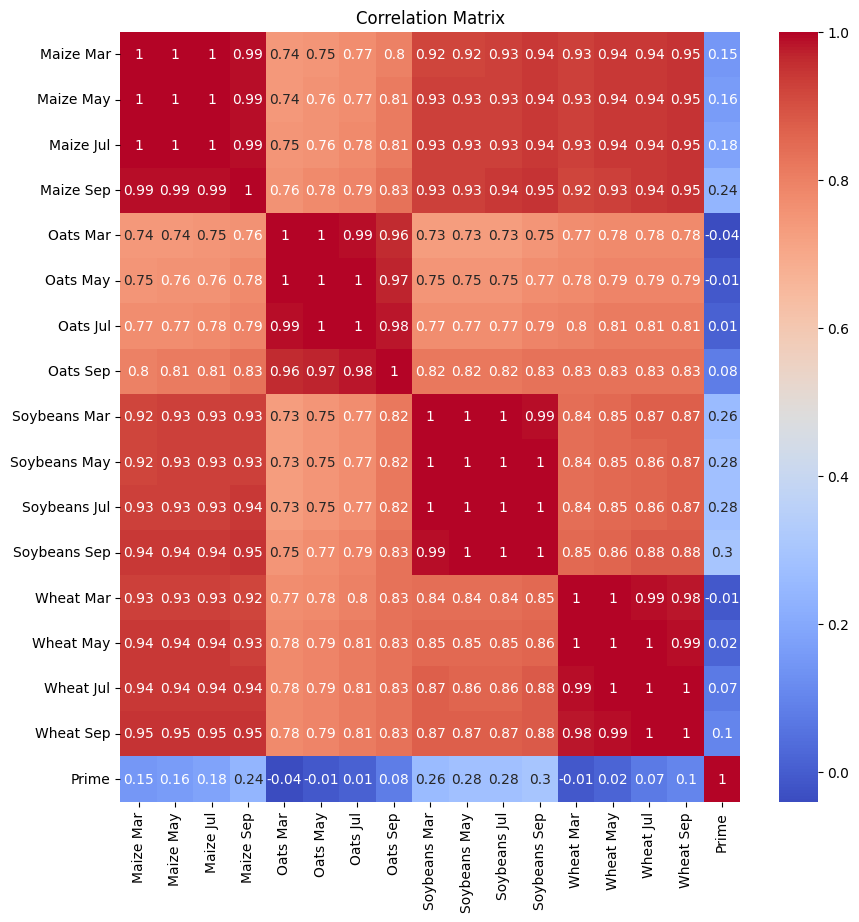

In [5]:
dataset = pd.read_csv(f'{DATA_PATH}/full_dataset.csv')
dataset.drop(columns=['Date', 'diff'], inplace=True)
correlation_matrix = dataset.corr()
correlation_matrix = correlation_matrix.round(2)
# visualize the correlation matrix


plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

We can see that exeppt for the Prime, all other variables are strongly (and even very strongly) correlated with each other. In order to demonestrate the strong connections between one variable and the others, we will use Linear Regression. Our mission isn't realy to predict the explained variables (as it does not make sense realisticaly), but to see the linear connections between the variables (in the correlation matrix we only see the connections between variables in pairs and here we will see the connections between one variable and all the others).

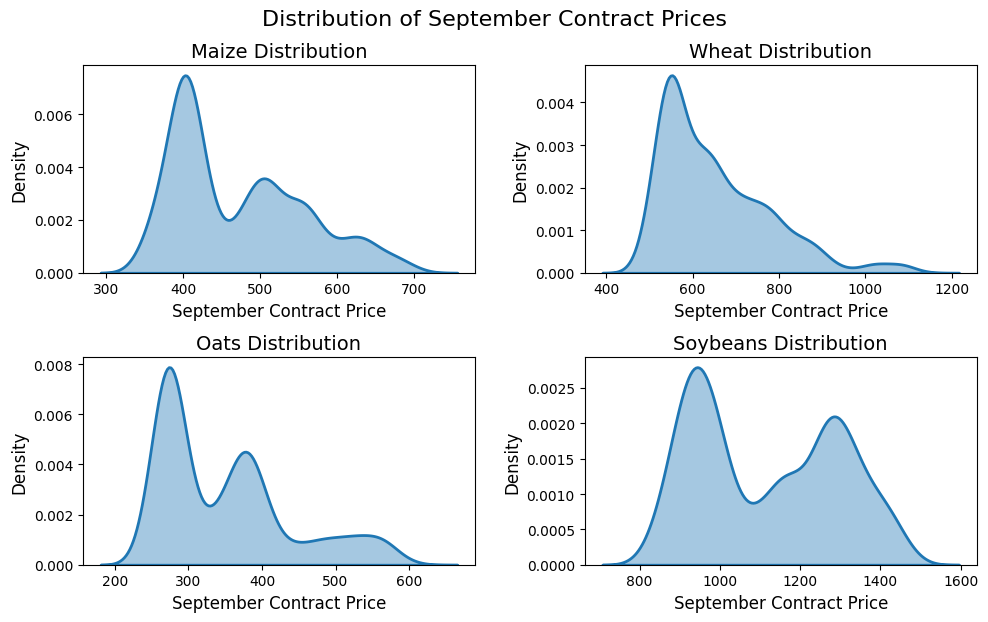

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))  # Create a 2x2 subplot layout
axes = axes.flatten()  # Flatten to easily iterate over subplots

for i, commodity in enumerate(commodities):   
    # Plot the distribution of Y_COLUMN
    col_name = f'{commodity} {Y_COLUMN}'
    sns.kdeplot(dataset[col_name], fill=True, alpha=0.4, linewidth=2, ax=axes[i])
    
    axes[i].set_title(f'{commodity} Distribution', fontsize=14)
    axes[i].set_xlabel('September Contract Price', fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)
    
# Adjust layout and add the overall title
plt.tight_layout(h_pad=1.0, w_pad=2.0)
fig.suptitle('Distribution of September Contract Prices', fontsize=16, y=1.03)
plt.show()

It can be observed that the different distributions share a similar structure, with a certain concentration of density on the left side. However, *soybeans* is an exception, as it also exhibits an additional concentration of density on the right side.

## Regression Missions

In [7]:
def train_and_evaluate(dataset, y_col):
    X_cols = [col for col in dataset.columns if col not in {'Date', 'diff', y_col}]
    X = dataset[X_cols]
    y = dataset[y_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)

    # Fit the OLS model
    model = sm.OLS(y_train, X_train_sm)
    results = model.fit()

    # Make predictions on the Test set
    y_pred = results.predict(X_test_sm)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    
    plot_data = {'Actual': y_test, 'Predicted': y_pred}

    return rmse, results, plot_data

Maize Dataset: RMSE = 8.1915, R^2 = 0.9906


Wheat Dataset: RMSE = 2.8537, R^2 = 0.9996


Oats Dataset: RMSE = 10.2147, R^2 = 0.9857


Soybeans Dataset: RMSE = 8.5534, R^2 = 0.9972


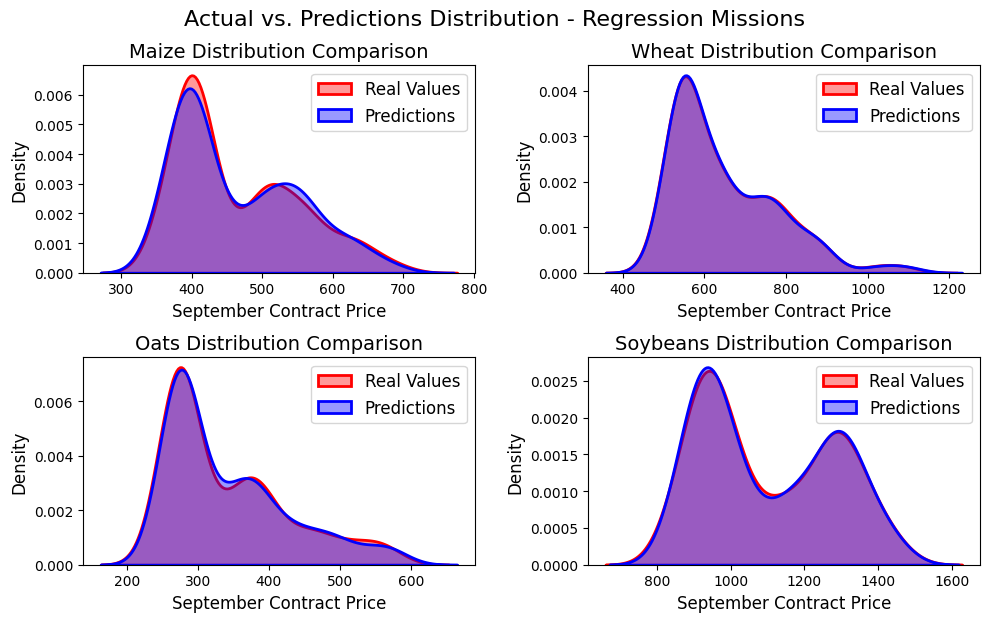

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

for i, commodity in enumerate(commodities):
    dataset = pd.read_csv(f'{DATA_PATH}/full_{commodity}.csv')
    rmse, results, plot_data = train_and_evaluate(dataset, Y_COLUMN)
    r_squared = results.rsquared
    pvalues = results.pvalues
    f_p_value = results.f_pvalue
    print(f'{commodity} Dataset: RMSE = {'{:.4f}'.format(rmse)}, R^2 = {'{:.4f}'.format(r_squared)}')
    if pvalues.max() > PROBLEM_PVALUE:
        print('Warning: Some features may not be significant', list(pvalues[pvalues > PROBLEM_PVALUE].index))
    if f_p_value > PROBLEM_PVALUE:
        print('Warning: The model may not be significant', f_p_value)
    # print(results.summary())
    if i < len(commodities) - 1:
        print('\n')
    sns.kdeplot(plot_data['Actual'], color='red', label='Real Values', fill=True, alpha=0.4, linewidth=2, ax=axes[i])
    sns.kdeplot(plot_data['Predicted'], color='blue', label='Predictions', fill=True, alpha=0.4, linewidth=2, ax=axes[i])
    axes[i].set_title(f'{commodity} Distribution Comparison', fontsize=14)
    axes[i].set_xlabel('September Contract Price', fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)
    axes[i].legend(fontsize=12)

plt.tight_layout(h_pad=1.0, w_pad=2.0)
fig.suptitle('Actual vs. Predictions Distribution - Regression Missions', fontsize=16, y=1.03)
plt.show()

We can see that the linear regression model is very accurate, and the R^2 is very high. This is because the variables are very correlated with each other.

Maize Sep Dataset: RMSE = 5.4095, R^2 = 0.9958


Wheat Sep Dataset: RMSE = 2.3057, R^2 = 0.9997


Oats Sep Dataset: RMSE = 6.6628, R^2 = 0.9937


Soybeans Sep Dataset: RMSE = 7.4680, R^2 = 0.9987


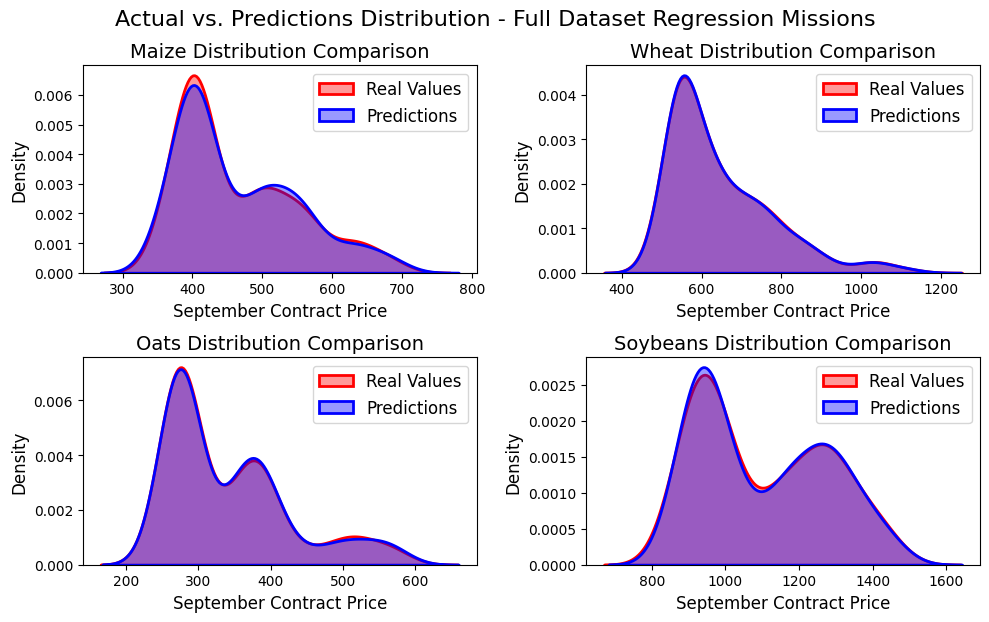

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

dataset = pd.read_csv(f'{DATA_PATH}/full_dataset.csv')
for i, commodity in enumerate(commodities):
    y_col = f'{commodity} {Y_COLUMN}'  
    rmse, results, plot_data = train_and_evaluate(dataset, y_col)  
    r_squared = results.rsquared
    pvalues = results.pvalues.round(5)
    f_p_value = results.f_pvalue.round(5)
    print(f'{y_col} Dataset: RMSE = {'{:.4f}'.format(rmse)}, R^2 = {'{:.4f}'.format(r_squared)}')
    if pvalues.max() > PROBLEM_PVALUE:
        print('Warning: Some features may not be significant', list(pvalues[pvalues > PROBLEM_PVALUE].index))
    if f_p_value > PROBLEM_PVALUE:
        print('Warning: The model may not be significant', f_p_value)
    # print(results.summary())
    if i < len(commodities) - 1:
        print('\n')
        
    sns.kdeplot(plot_data['Actual'], color='red', label='Real Values', fill=True, alpha=0.4, linewidth=2, ax=axes[i])
    sns.kdeplot(plot_data['Predicted'], color='blue', label='Predictions', fill=True, alpha=0.4, linewidth=2, ax=axes[i])
    axes[i].set_title(f'{commodity} Distribution Comparison', fontsize=14)
    axes[i].set_xlabel('September Contract Price', fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)
    axes[i].legend(fontsize=12)

plt.tight_layout(h_pad=1.0, w_pad=2.0)
fig.suptitle('Actual vs. Predictions Distribution - Full Dataset Regression Missions', fontsize=16, y=1.03)
plt.show()

Here we demonstrate how adding information about the other commodities can help us predict the price of one commodity future contract.